<a href="https://colab.research.google.com/github/saharshleo/sudokuSolver/blob/master/digit_classifier/digit_classifier_conv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical # convert to one-hot-encoding
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler

import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

print(tf.__version__)

2.2.0


In [2]:
# load data
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
print(x_train.shape)
print(x_test.shape)

11493376/11490434 [==============================] - 0s 0us/step
(60000, 28, 28)
(10000, 28, 28)


In [3]:
# normalize data
x_train = tf.keras.utils.normalize(x_train, axis=1)
x_test = tf.keras.utils.normalize(x_test, axis=1)

In [4]:
# Reshape
X_train = x_train.reshape(-1,28,28,1)
X_test = x_test.reshape(-1,28,28,1)

print(X_train.shape)
print(X_test.shape)

# Encode labels to one hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
Y_train_value = y_train # keep the origianl label
Y_train = to_categorical(y_train, num_classes = 10)
# Y_train = tf.keras.backend.one_hot(y_train, num_classes=10)
print(Y_train.shape)

Y_test_value = y_test # keep the origianl label
Y_test = to_categorical(y_test, num_classes = 10)
# Y_test = tf.keras.backend.one_hot(y_test, num_classes=10)
print(Y_test.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)
(60000, 10)
(10000, 10)


In [16]:
# # With data augmentation to prevent overfitting
# datagen = ImageDataGenerator(
#         rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
#         zoom_range = 0.1, # Randomly zoom image 
#         width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
#         height_shift_range=0.1)  # randomly shift images vertically (fraction of total height)

# datagen.fit(X_train)


# https://medium.com/@lvarruda/how-to-get-top-2-position-on-kaggles-mnist-digit-recognizer-48185d80a2d4
from tensorflow.keras.callbacks import ReduceLROnPlateau
datagen = ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        rotation_range=10,
        zoom_range=0.1,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=False,
        vertical_flip=False)  # , preprocessing_function=random_add_or_erase_spot)

annealer = ReduceLROnPlateau(monitor='val_accuracy', patience=1, verbose=2, factor=0.5, min_lr=0.0000001) #patience=2

In [ ]:
# Callback for stop training after threshold accuracy
ACCURACY_THRESHOLD = 0.99
class CustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy') > ACCURACY_THRESHOLD):
            print("\nReached %2.2f%% accuracy, stopping training!"%(ACCURACY_THRESHOLD*100))
            self.model.stop_training = True
            
callbacks = CustomCallback()

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1)

# Set a learning rate annealer
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x)

In [8]:
# # Conv model https://www.kaggle.com/dingli/digits-recognition-with-cnn-keras
# classify_digit_conv.model
# model = tf.keras.models.Sequential()
# model.add(Conv2D(filters=16, kernel_size=(3,3), activation='relu', input_shape=(28, 28, 1)))
# model.add(BatchNormalization())
# model.add(Conv2D(filters = 16, kernel_size = (3, 3), activation='relu'))
# model.add(BatchNormalization())
# model.add(MaxPool2D(strides=(2,2)))
# model.add(Dropout(0.25))

# model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation='relu'))
# model.add(BatchNormalization())
# model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation='relu'))
# model.add(BatchNormalization())
# model.add(MaxPool2D(strides=(2,2)))
# model.add(Dropout(0.25))

# model.add(Flatten())
# model.add(Dense(512, activation='relu'))
# model.add(Dropout(0.25))
# model.add(Dense(1024, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(10, activation='softmax'))
# model.summary()

# https://medium.com/@lvarruda/how-to-get-top-2-position-on-kaggles-mnist-digit-recognizer-48185d80a2d4
# classify_digit_conv2.model
model = tf.keras.models.Sequential()
model.add(Conv2D(filters=32, kernel_size=(5, 5), padding='Valid', activation='relu', input_shape=(28, 28, 1)))
model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='Same', activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=(5, 5), padding='Valid', activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='Same', activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(519, activation="relu"))  # [[521,0.9962,70],[519,0.9969,51]
model.add(Dropout(0.5))
model.add(Dense(10, activation="softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 24, 24, 32)        832       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 64)          51264     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 64)          36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 64)          0

In [9]:
# Define the optimizer
optimizer = Adam(lr=1e-4)

# Compile the model
# model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-3), metrics=["accuracy"])

In [10]:
# Turn epochs to 30 to get 0.9967 accuracy
epochs = 30
# batch_size = 86
batch_size = 64

In [17]:
# # Fit the model
# history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
#                               epochs = epochs, validation_data = (X_test,Y_test),
#                               verbose = 1, steps_per_epoch=X_train.shape[0] // batch_size
#                               , callbacks=[annealer])

history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_test,Y_test),
                              verbose = 1, steps_per_epoch=X_train.shape[0] // batch_size,
                              callbacks=[annealer])

Epoch 1/30
937/937 [==============================] - 29s 31ms/step - loss: 0.0283 - accuracy: 0.9914 - val_loss: 0.0165 - val_accuracy: 0.9954 - lr: 0.0010
Epoch 2/30
936/937 [============================>.] - ETA: 0s - loss: 0.0259 - accuracy: 0.9919
Epoch 00002: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
937/937 [==============================] - 29s 31ms/step - loss: 0.0260 - accuracy: 0.9919 - val_loss: 0.0231 - val_accuracy: 0.9949 - lr: 0.0010
Epoch 3/30
937/937 [==============================] - 29s 31ms/step - loss: 0.0195 - accuracy: 0.9938 - val_loss: 0.0146 - val_accuracy: 0.9955 - lr: 5.0000e-04
Epoch 4/30
936/937 [============================>.] - ETA: 0s - loss: 0.0181 - accuracy: 0.9944
Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
937/937 [==============================] - 29s 30ms/step - loss: 0.0181 - accuracy: 0.9944 - val_loss: 0.0143 - val_accuracy: 0.9954 - lr: 5.0000e-04
Epoch 5/30
937/937 [==============

In [18]:
# Save the model
model.save('classify_digit_conv.model')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: classify_digit_conv.model/assets


In [19]:
new_model = tf.keras.models.load_model('classify_digit_conv.model')

6


<function matplotlib.pyplot.show>

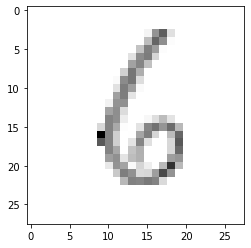

In [20]:
# Make predictions
predictions = new_model.predict(X_test)

test_example = 140
print(np.argmax(predictions[test_example]))
plt.imshow(x_test[test_example], cmap=plt.cm.binary)
plt.show

In [21]:
from google.colab import files
!zip -r /content/model.zip /content/classify_digit_conv.model
files.download("/content/model.zip")

  adding: content/classify_digit_conv.model/ (stored 0%)
  adding: content/classify_digit_conv.model/assets/ (stored 0%)
  adding: content/classify_digit_conv.model/variables/ (stored 0%)
  adding: content/classify_digit_conv.model/variables/variables.data-00000-of-00002 (deflated 81%)
  adding: content/classify_digit_conv.model/variables/variables.data-00001-of-00002 (deflated 7%)
  adding: content/classify_digit_conv.model/variables/variables.index (deflated 68%)
  adding: content/classify_digit_conv.model/saved_model.pb (deflated 89%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>